<a href="https://colab.research.google.com/github/Sankalpa0011/DCGAN-Handwritten-Digits-Generator/blob/main/DCGAN_Handwritten_Digits_Generator_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
print(img_shape)

(28, 28, 1)


In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

def build_generator():

  noise_shape = (100,)

  model = Sequential()

  model.add(Dense(256, input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))

  return model

In [3]:
def build_discriminator():

  model = Sequential()

  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [4]:
(train_data, train_target), (test_data, test_target) = mnist.load_data()
print(train_data.shape)
print(train_target.shape)
print(test_data.shape)
print(test_target.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


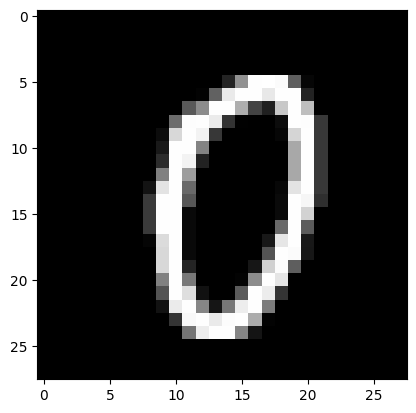

In [5]:
plt.imshow(train_data[1000], cmap="gray")
plt.show()

In [6]:
def train(epochs, batch_size=128, save_interval=50):
    # Load the MNIST dataset
    (train_data, _), (_, _) = mnist.load_data()

    # Normalize the training data to range [-1, 1] and reshape it to include the channel dimension
    train_data = (train_data.astype(np.float32) - 127.5) / 127.5
    train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)

    # Calculate half of the batch size (used for discriminator training)
    half_batch = int(batch_size / 2)

    # Training loop for the specified number of epochs
    for epoch in range(epochs):

        # Select a random batch of real images
        idx = np.random.randint(0, train_data.shape[0], half_batch)
        imgs = train_data[idx]


        # Generate a batch of fake images (noise to generator)
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)


        # Enable training for the discriminator
        discriminator.trainable = True


        # Train the discriminator on real images (label as 1)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        # Train the discriminator on fake images (label as 0)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))


        # Average the discriminator's loss on real and fake images
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # Generate a new batch of noise inputs for the generator training
        gan_train_noise = np.random.normal(0, 1, (batch_size, 100))
        # Target for the generator is to trick the discriminator (label fake images as 1)
        gan_train_target = np.ones((batch_size, 1))


        # Disable training for the discriminator while training the generator
        discriminator.trainable = False


        # Train the generator via the GAN model
        g_loss = GAN.train_on_batch(gan_train_noise, gan_train_target)


        # Print the progress after each epoch
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))


        # Save generated images at intervals specified by save_interval
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [7]:
idx = np.random.randint(0, 100, 50)
print(idx)

[39 95 97 22 37 45 21 79 46 70 62 19 12 28 60 32 18 86 23 49 15 60 38 97
 91  0 30 78 38 16 65 94 11 15 95 68 18 15  7 76 95 49 88 71 24 56 85 95
 44 87]


In [8]:
import os
import matplotlib.pyplot as plt

def save_imgs(epoch):
    # Path to the directory of the notebook in Google Drive
    notebook_dir = "/content/drive/My Drive/DL Projects"
    save_dir = os.path.join(notebook_dir, "images")  # Save in 'images' subdirectory

    # Ensure the 'images' directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Dimensions for the grid
    r, c = 5, 5

    # Generate images
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Plot and save the images
    fig, axs = plt.subplots(r, c, figsize=(10, 10))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.tight_layout()
    fig.savefig(f"{save_dir}/mnist_{epoch}.png")
    plt.close()

In [9]:
from keras.optimizers.legacy import Adam

# Define optimizer
optimizer = Adam(0.0002, 0.5)  # Learning rate and momentum

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# Input for GAN
noise_input = Input(shape=(100,))   # Our random input to the generator
generator_output = generator(noise_input)

# Freeze the discriminator for GAN training
discriminator.trainable = False

# Create the GAN model
discriminator_output = discriminator(generator_output)    # Validity check on the generated image

GAN = Model(noise_input, discriminator_output)
GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

# Train the GAN
train(epochs=10000, batch_size=32, save_interval=10)

# Save the generator model
generator.save("generator_model.h5")  # Test the model on GAN_predict...

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
7619 [D loss: 0.753594, acc.: 43.75%] [G loss: 0.872401]
1/1 [==============================] - 0s 25ms/step
7620 [D loss: 0.683227, acc.: 53.12%] [G loss: 0.821005]
1/1 [==============================] - 0s 25ms/step
7621 [D loss: 0.633727, acc.: 75.00%] [G loss: 0.820305]
1/1 [==============================] - 0s 26ms/step
7622 [D loss: 0.746485, acc.: 34.38%] [G loss: 0.931225]
1/1 [==============================] - 0s 26ms/step
7623 [D loss: 0.681009, acc.: 50.00%] [G loss: 0.905644]
1/1 [==============================] - 0s 26ms/step
7624 [D loss: 0.613146, acc.: 56.25%] [G loss: 0.940283]
1/1 [==============================] - 0s 26ms/step
7625 [D loss: 0.771956, acc.: 53.12%] [G loss: 0.966805]
1/1 [==============================] - 0s 24ms/step
7626 [D loss: 0.675354, acc.: 59.38%] [G loss: 0.995182]
1/1 [==============================] - 0s 25ms/step
7627 [D loss: 0.667007, a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
